In [12]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import seaborn as sns
from pyspark.sql import functions as F

In [13]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [37]:
# # Read the Parquet file into a Spark DataFrame
# prop_data_df = spark.read.parquet("../data/curated/prop_data_cleaned.parquet")

sdf = spark.read.parquet("../data/curated/prop_data_cleaned2.parquet")
  
csv_df = spark.read.csv("../data/curated/postcode_data.csv", header=True, inferSchema=True)

csv_df = csv_df.withColumnRenamed("poa_code", "postal_code")

csv_df = csv_df.withColumn(
    "pop_percentage_increase", 
    (F.col("2023_pop") - F.col("2022_pop")) / F.col("2022_pop") * 100
)

# think income is by year so divide it by 52 to get weekly income 
csv_df = csv_df.select("median_inc", "2022_pop", "2023_pop", 'pop_percentage_increase', 'postal_code')

prop_data_df = sdf.join(csv_df, on="postal_code", how="inner")

prop_data_df

postal_code,name,property_url,beds,baths,parkings,cost,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks,schools,supermarkets,hospitals,shopping_districts,CBD,train_stations,median_inc,2022_pop,2023_pop,pop_percentage_increase
3000,1001/39 queen str...,https://www.domai...,3,1,1,825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.061605369006616,28.534222889289346,3.789252665496929,2.3309194096840105,2.044399536959844,10.501326289853436,2.6808484013722285,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,2817s/220 spencer...,https://www.domai...,2,2,1,800,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,4.450339524690075,146.9693411848118,3.1176640574855794,1.6229010507904305,2.4024416175246754,15.296012310127612,3.5548872520965213,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,3207/80 a'beckett...,https://www.domai...,2,1,1,760,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0,5.126558289688815,43.900895757707104,3.792978958885551,2.569931859332177,1.619535497477752,8.53594220120455,5.269945056370016,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,1413/199 william ...,https://www.domai...,2,1,1,650,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,5.106021911950458,7.155985097948747,1.3951717418235312,2.902103212576152,2.2846453313988775,12.204132879191926,2.3991200077445223,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,2505/371 little l...,https://www.domai...,1,1,1,550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.158540377705488,161.57042692840125,2.015627531131723,2.0033646611042384,1.546306478195376,3.839252115744486,3.713067868741022,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,1910/22 - 24 jane...,https://www.domai...,1,1,1,525,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5.552956384055543,131.02427608317888,1.75329880860125,2.3618347792874785,1.8288431276619488,8.302214615695416,3.463406995507932,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,208/547 flinders ...,https://www.domai...,2,1,1,525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5.739980408559591,50.739713830923286,3.763214104491426,2.5576578805030015,1.9643295863415091,0.51635329099994,5.6359587472386234,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,303/18-20 bank pl...,https://www.domai...,1,1,1,525,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,5.1423956172298775,52.972111465968375,3.2133318837099427,1.5862804848095144,2.251370296338508,2.78501311363486,4.101042305128395,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,2704/288 spencer ...,https://www.domai...,1,1,1,480,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0,5.850449601072672,50.92845857055024,3.173526347724434,1.0015159441326353,2.1299875173916183,15.4685708602206,5.531736563799649,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,819/555 flinders ...,https://www.domai...,1,1,1,525,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,4.847495275309207,156.0834676655126,1.5218799570036476,1.1312855547598168,1.7563903352438626,14.453102125284074,8.9808561770651,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387


In [38]:
# Define the schema for the UDF's return type
import pyspark, re, json, os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, regexp_replace, lower, explode, array_contains, collect_set, lit, coalesce, array, count, when, isnull, mean, rand
from pyspark.sql.types import IntegerType, StringType, FloatType, StructType, StructField
from pyspark.ml.feature import StringIndexer
import pandas as pd

address_schema = StructType([
    StructField("unit_floor", StringType(), True),
    StructField("street", StringType(), True),
    StructField("suburb", StringType(), True),
    StructField("state", StringType(), True),
    StructField("post_code", StringType(), True)
])

# Define the UDF to handle complex address formats, including 'suburb state postcode'
def extract_address_components(name):
    # Clean double commas first if any
    name = re.sub(r",,", ",", name)

    # Initialize all components as None
    unit_floor, street, suburb, state, postcode = None, None, None, None, None

    # Split the address based on commas
    parts = [part.strip().lower() for part in name.split(',')]

    # Handle cases based on the number of parts found
    if len(parts) >= 1:
        # Check the last part for 'suburb state postcode'
        suburb_state_postcode = parts[-1]
        state_postcode_match = re.search(r'([a-z]{2,3})\s+(\d{4})$', suburb_state_postcode)
        if state_postcode_match:
            state = state_postcode_match.group(1)
            postcode = state_postcode_match.group(2)
            suburb = suburb_state_postcode[:-(len(state + postcode) + 2)].strip() # just added the plus 2 because melb suburb 

        # Check if there is a unit/floor number or a street
        if len(parts) == 1:
            # Only suburb, state, postcode available
            pass
        elif len(parts) == 2:
            # Could be 'street, suburb state postcode'
            street = parts[0]
        elif len(parts) >= 3:
            # Complex structure with unit/floor number
            unit_floor = parts[0]
            street = ', '.join(parts[1:-1])  # Combine middle parts as street

    return (unit_floor, street, suburb, state, postcode)

# Register the UDF with the schema
extract_address_udf = udf(extract_address_components, address_schema)

# Apply the UDF to create new columns for each address component
prop_data_df = prop_data_df.withColumn("AddressComponents", extract_address_udf(sdf['name']))
prop_data_df = prop_data_df.select(*prop_data_df.columns, "AddressComponents.*")
columns_to_drop = ['AddressComponents']

# Dropping the columns from the DataFrame
prop_data_df = prop_data_df.drop(*columns_to_drop)
prop_data_df

postal_code,name,property_url,beds,baths,parkings,cost,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks,schools,supermarkets,hospitals,shopping_districts,CBD,train_stations,median_inc,2022_pop,2023_pop,pop_percentage_increase,unit_floor,street,suburb,state,post_code
3000,1001/39 queen str...,https://www.domai...,3,1,1,825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.061605369006616,28.534222889289346,3.789252665496929,2.3309194096840105,2.044399536959844,10.501326289853436,2.6808484013722285,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,1001/39 queen street,melbourne,vic,3000
3000,2817s/220 spencer...,https://www.domai...,2,2,1,800,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,4.450339524690075,146.9693411848118,3.1176640574855794,1.6229010507904305,2.4024416175246754,15.296012310127612,3.5548872520965213,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,2817s/220 spencer...,melbourne,vic,3000
3000,3207/80 a'beckett...,https://www.domai...,2,1,1,760,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0,5.126558289688815,43.900895757707104,3.792978958885551,2.569931859332177,1.619535497477752,8.53594220120455,5.269945056370016,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,3207/80 a'beckett...,melbourne,vic,3000
3000,1413/199 william ...,https://www.domai...,2,1,1,650,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,5.106021911950458,7.155985097948747,1.3951717418235312,2.902103212576152,2.2846453313988775,12.204132879191926,2.3991200077445223,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,1413/199 william ...,melbourne,vic,3000
3000,2505/371 little l...,https://www.domai...,1,1,1,550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,6.158540377705488,161.57042692840125,2.015627531131723,2.0033646611042384,1.546306478195376,3.839252115744486,3.713067868741022,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,2505/371 little l...,melbourne,vic,3000
3000,1910/22 - 24 jane...,https://www.domai...,1,1,1,525,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5.552956384055543,131.02427608317888,1.75329880860125,2.3618347792874785,1.8288431276619488,8.302214615695416,3.463406995507932,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,1910/22 - 24 jane...,melbourne,vic,3000
3000,208/547 flinders ...,https://www.domai...,2,1,1,525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,5.739980408559591,50.739713830923286,3.763214104491426,2.5576578805030015,1.9643295863415091,0.51635329099994,5.6359587472386234,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,208/547 flinders ...,melbourne,vic,3000
3000,303/18-20 bank pl...,https://www.domai...,1,1,1,525,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,5.1423956172298775,52.972111465968375,3.2133318837099427,1.5862804848095144,2.251370296338508,2.78501311363486,4.101042305128395,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,303/18-20 bank place,melbourne,vic,3000
3000,2704/288 spencer ...,https://www.domai...,1,1,1,480,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0,5.850449601072672,50.92845857055024,3.173526347724434,1.0015159441326353,2.1299875173916183,15.4685708602206,5.531736563799649,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,NULL,2704/288 spencer ...,melbourne,vic,3000
3000,819/555 flinders ...,https://www.domai...,1,1,1,525,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,4.847495275309207,156.0834676655126,1.5218799570036476,1.1312855547598168,1.75639033

In [39]:
from pyspark.sql.functions import collect_set

# Group by 'postal_code' and collect unique suburbs into a list
grouped_by_postcode = prop_data_df.groupBy("postal_code").agg(collect_set("suburb").alias("unique_suburbs"))

csv_df = spark.read.csv("../data/curated/rent_historical_data.csv", header=True, inferSchema=True)



+-----------+-------------------------------------------------------------------+
|postal_code|unique_suburbs                                                     |
+-----------+-------------------------------------------------------------------+
|3000       |[melbourne]                                                        |
|3002       |[east melbourne]                                                   |
|3003       |[west melbourne]                                                   |
|3004       |[melbourne, melbourne 3004]                                        |
|3006       |[south wharf, southbank]                                           |
|3008       |[docklands]                                                        |
|3011       |[seddon, footscray]                                                |
|3012       |[west footscray, maidstone, brooklyn, kingsville]                  |
|3013       |[yarraville]                                                       |
|3015       |[sp

In [15]:
# Show the first few rows to understand what the data looks like
prop_data_df.show(truncate=False)

+-----------+---------------------------------------------------+-------------------------------------------------------------------------------------+----+-----+--------+----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------------+
|postal_code|name                                               |property_url                                                                         |beds|baths|parkings|cost|built_in_wardrobes|dishwasher|air_conditioning|floorboards|secure_parking|intercom|heating

In [16]:
# Print the schema to see the column names and types
prop_data_df.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

In [17]:
prop_data_df = prop_data_df.drop("unit_floor", "street", "suburb", "state")

prop_data_df = prop_data_df.withColumn("postal_code", col("postal_code").cast("int"))

prop_data_df.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

## OUTLIER ANALYSIS

In [18]:
prop_data_df.describe()

summary,postal_code,name,property_url,beds,baths,parkings,cost,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks,schools,supermarkets,hospitals,shopping_districts,CBD,train_stations,median_inc,2022_pop,2023_pop,pop_percentage_increase
count,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131,11131
mean,3166.0352169616385,NULL,NULL,2.566795436169257,1.561944120025155,1.4535082202856886,631.9261521875842,0.350372832629593,0.2548737759410655,0.2209145629323511,0.14733626808013656,0.1366454047255413,0.13457910340490523,0.09181564998652413,0.09037822298086426,0.08633545952744587,0.07528523942143563,0.07133231515587099,0.0696253705866499,0.06809810439313628,0.06594196388464649,0.06306710987332674,0.0625280747462043,0.06270775312191178,0.0586649896684934,0.05632917078429611,0.05336447758512263,0.05102865870092534,0.05039978438594915,0.051477854640194054,0.05022010601024167,0.04132602641272123,0.7305722756266283,5.2866516639251016,91.67040277906689,2.6248019711875012,2.3777985395122676,1.980070358094537,8.805410596117206,5.803225018385905,56154.412095402964,15328.05031882398,16312.984388145544,6.364452041093027
stddev,237.52339577298156,NULL,NULL,1.0960636746579084,0.620265682955433,0.649741845480189,242.97810573170696,0.4771081230425537,0.4358098179863519,0.41488164884351175,0.35445673861014765,0.34348804590998444,0.3412887818600112,0.2887785109145376,0.28673574268807733,0.28087138561187897,0.26386289446757144,0.25739069100042955,0.25452602706640665,0.2519254936403071,0.24819177122089903,0.2430945465629299,0.24212307058533514,0.24244746160168043,0.23500717080043643,0.23056663080665313,0.22476932376363198,0.22006609353060597,0.21877830371828702,0.22098025290398757,0.21840863650820305,0.19905211764534625,0.8536684884102298,0.5396240581101199,51.46221265723488,0.7354265059949847,0.8101790060107582,0.2634168081874697,4.843997650898117,2.0039399154076203,11519.683806776296,4328.658784069804,4678.910690167945,5.111735553550705
min,3000,(leased) 3 yarra ...,https://www.domai...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,4.352,3.932499999999999,1.3477383742911149,0.978061224489796,1.5214833333333335,0.4428,2.3484,7243.856856902629,1109.096895121673,1205.3499371813118,-0.6101926971050975
max,3978,x03/342-346 centr...,https://www.domai...,5,4,5,2200,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11.0,6.216900000000001,179.5314888888889,3.9118819999999994,3.768220408163265,2.4369124999999996,17.232400000000002,9.2718,81648.0,28244.0,30758.0,22.49100059837248


In [19]:
# Define the columns to calculate percentiles for
columns = ["beds", "baths", "parkings", "cost"]

# Define the percentiles to calculate
percentiles = [0.01, 0.05, 0.1, 0.2, 0.9, 0.95, 0.97, 0.99, 0.995, 0.999]

# Calculate percentiles for each column
percentile_values = {col: prop_data_df.approxQuantile(col, percentiles, 0.001) for col in columns}

# Prepare data for DataFrame creation
rows = []
for col, values in percentile_values.items():
    data = {f"{(p*100)} th_percentile": val for p, val in zip(percentiles, values)}
    row = Row(column=col, **data)
    rows.append(row)

# Create DataFrame from the list of Row objects
percentile_df = spark.createDataFrame(rows)

# Show the DataFrame
percentile_df

column,1.0 th_percentile,5.0 th_percentile,10.0 th_percentile,20.0 th_percentile,90.0 th_percentile,95.0 th_percentile,97.0 th_percentile,99.0 th_percentile,99.5 th_percentile,99.9 th_percentile
beds,1.0,1.0,1.0,2.0,4.0,4.0,4.0,5.0,5.0,5.0
baths,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,4.0
parkings,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,5.0
cost,69.0,360.0,425.0,480.0,895.0,1100.0,1250.0,1550.0,1750.0,2200.0


In [20]:
# Define the 99.5th percentile thresholds for each column
upper_limits = {
    "beds": 5,       # 99.5th percentile for beds
    "parkings": 4,   # 99.5th percentile for parkings
    "cost": 800     # 99.5th percentile for cost (assuming cost values are in thousands or as applicable)
}

In [21]:
prop_data_df.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

In [22]:
from pyspark.sql.functions import col

In [23]:
# Filter the DataFrame to keep only entries within the 99.5th percentile
prop_data_df = prop_data_df.filter(
    (col("beds") <= upper_limits["beds"]) &
    (col("parkings") <= upper_limits["parkings"]) &
    (col("cost") <= upper_limits["cost"])
)

# Show some entries to verify the filter
prop_data_df.count()

9568

In [41]:
prop_data_df.write.parquet("../data/curated/prop_data_cleaned2.parquet", mode="overwrite")

## DISTRIBUTIONS

In [89]:
sns.set(style="whitegrid")

In [24]:
columns_of_interest = ['beds', 'baths', 'parkings', 'cost', 'prop_type_index', 'parks',
                       'schools', 'supermarkets', 'hospitals', 'shopping_districts', 'CBD',
                       'train_stations']

# Convert Spark DataFrame to Pandas, selecting only the columns of interest
pandas_df = prop_data_df.select(*columns_of_interest).toPandas()

In [25]:
# Define the number of subplots based on the DataFrame's number of columns
pandas_df.columns

Index(['beds', 'baths', 'parkings', 'cost', 'prop_type_index', 'parks',
       'schools', 'supermarkets', 'hospitals', 'shopping_districts', 'CBD',
       'train_stations'],
      dtype='object')

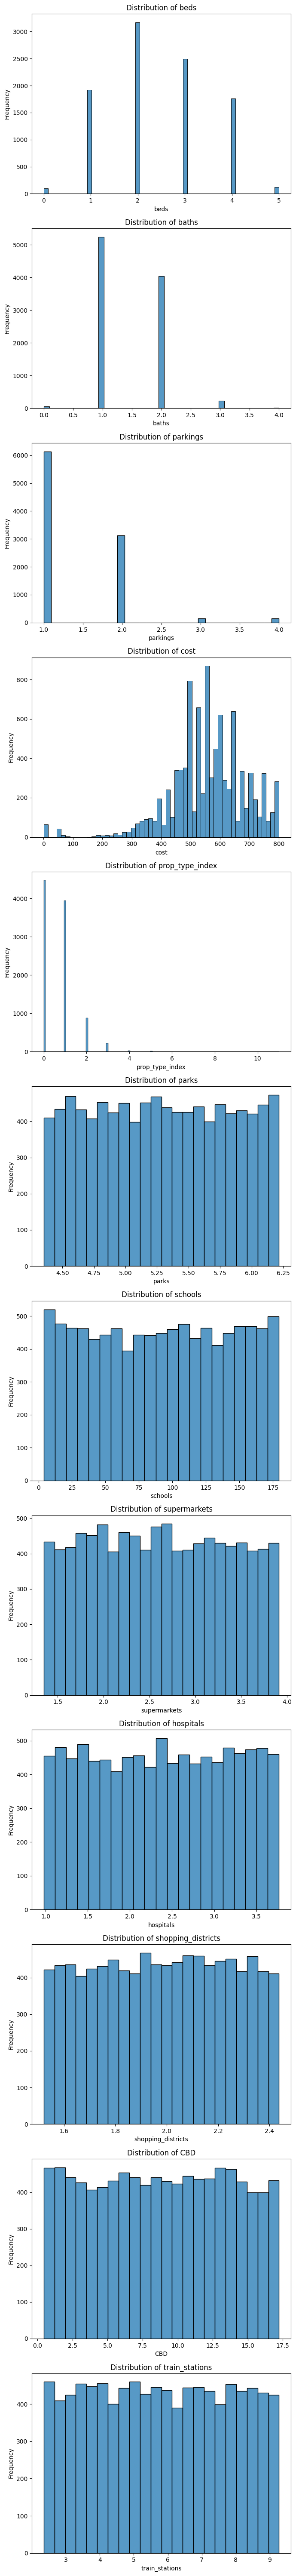

In [26]:
# Define the number of subplots based on the selected columns
fig, axes = plt.subplots(nrows=len(columns_of_interest), ncols=1, figsize=(7, 5 * len(columns_of_interest)))

# Check if only one subplot (axes can be a single AxesSubplot object instead of an array when only one plot)
if len(columns_of_interest) == 1:
    axes = [axes]

# Iterate through each column and create a histogram
for ax, column in zip(axes, columns_of_interest):
    sns.histplot(pandas_df[column], kde=False, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Central Tendency and Spread

The histogram shows a **unimodal distribution** with a peak around **200-300 units** of cost (assuming this might be in thousands or as per your specific measurement unit). The data is **right-skewed**, indicating that most properties are clustered at the lower end of the cost spectrum, with fewer properties having a higher cost.

### High Frequency of Lower Costs

There's a significant frequency of properties costing between **100 and 400 units**, which might represent the more affordable segment of the market.

### Long Tail to the Right

The long tail extending towards the higher cost values (over **500 units**) suggests the presence of **high-end properties** that are less frequent but significantly more expensive than the typical properties in the dataset. This tail includes some properties that approach **2000 units** in cost, representing the **luxury market segment**.

### Potential Outliers

Properties with costs approaching **2000 units** could be considered **outliers** compared to the majority of the data, or they might represent a distinct segment of the market (e.g., **luxury real estate**).

In [27]:
df_prop = prop_data_df.toPandas()

df_prop = df_prop.select_dtypes(exclude=['object'])

In [28]:
correlation_matrix = df_prop.corr()  # Compute the correlation matrix

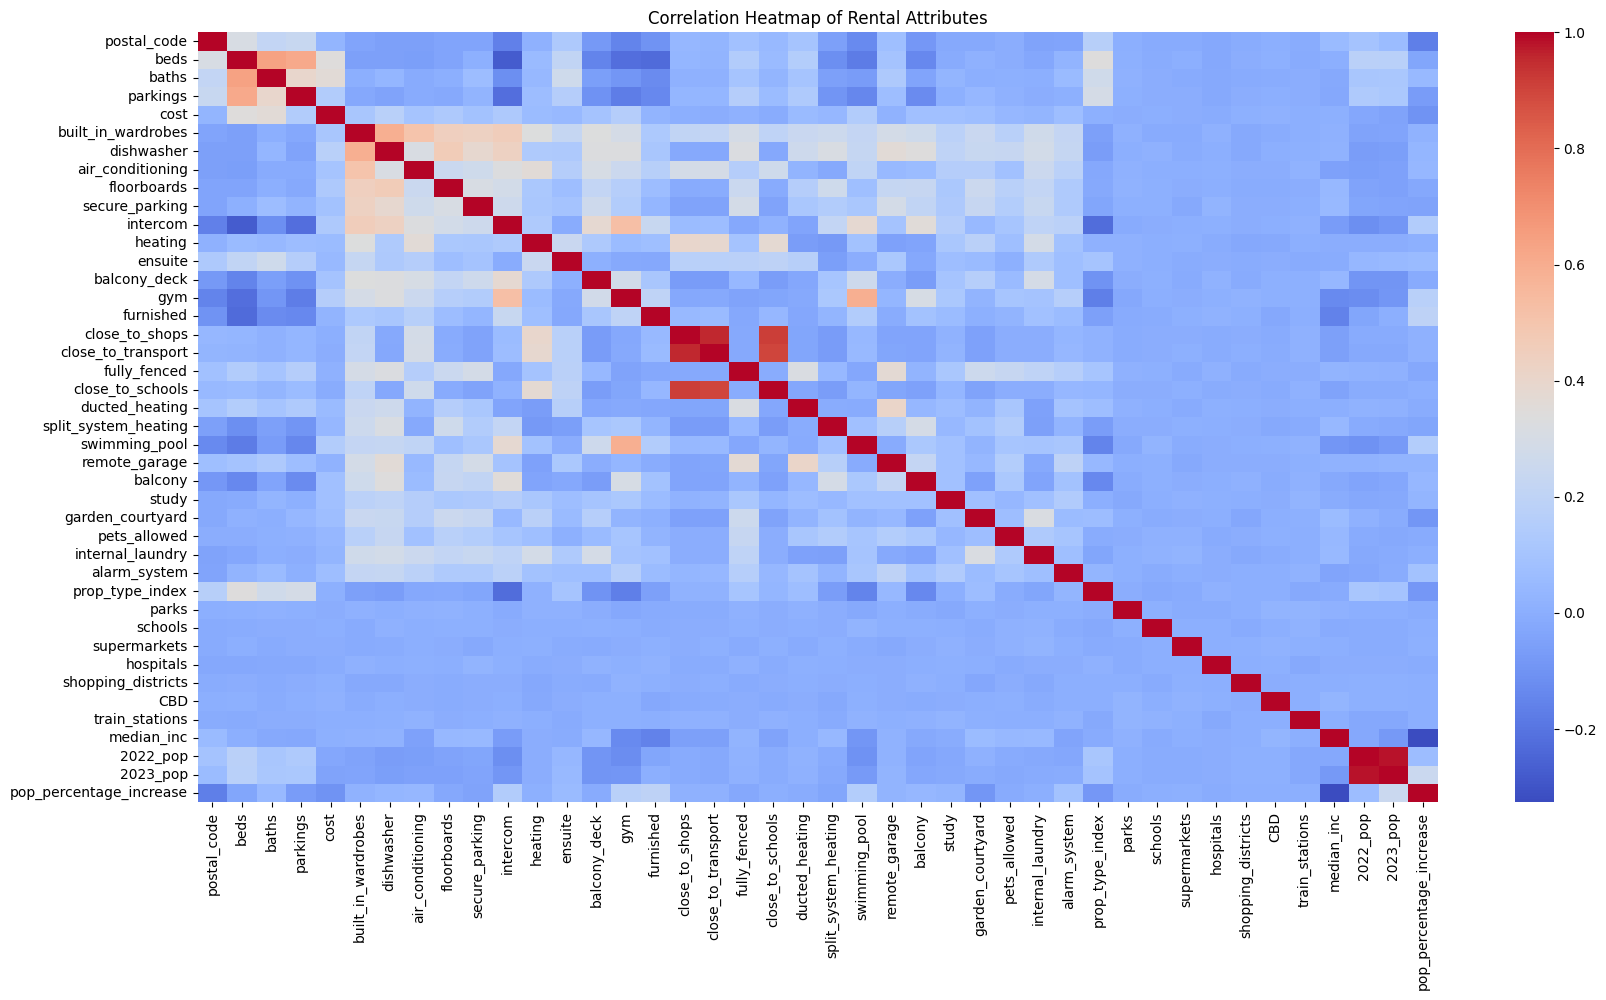

In [29]:
# Create and display the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Rental Attributes')
plt.show()

### Beds and Baths

There is a clear and strong **positive correlation** between the number of beds and baths. This is expected in residential properties, where more bedrooms typically correlate with additional bathrooms. This relationship could be useful in predicting rental prices, as properties with more amenities generally command higher rents.

The strong correlations (like that between beds and baths) should be monitored when used in regression models. High multicollinearity can inflate standard errors, making it difficult to ascertain the individual effect of each feature.

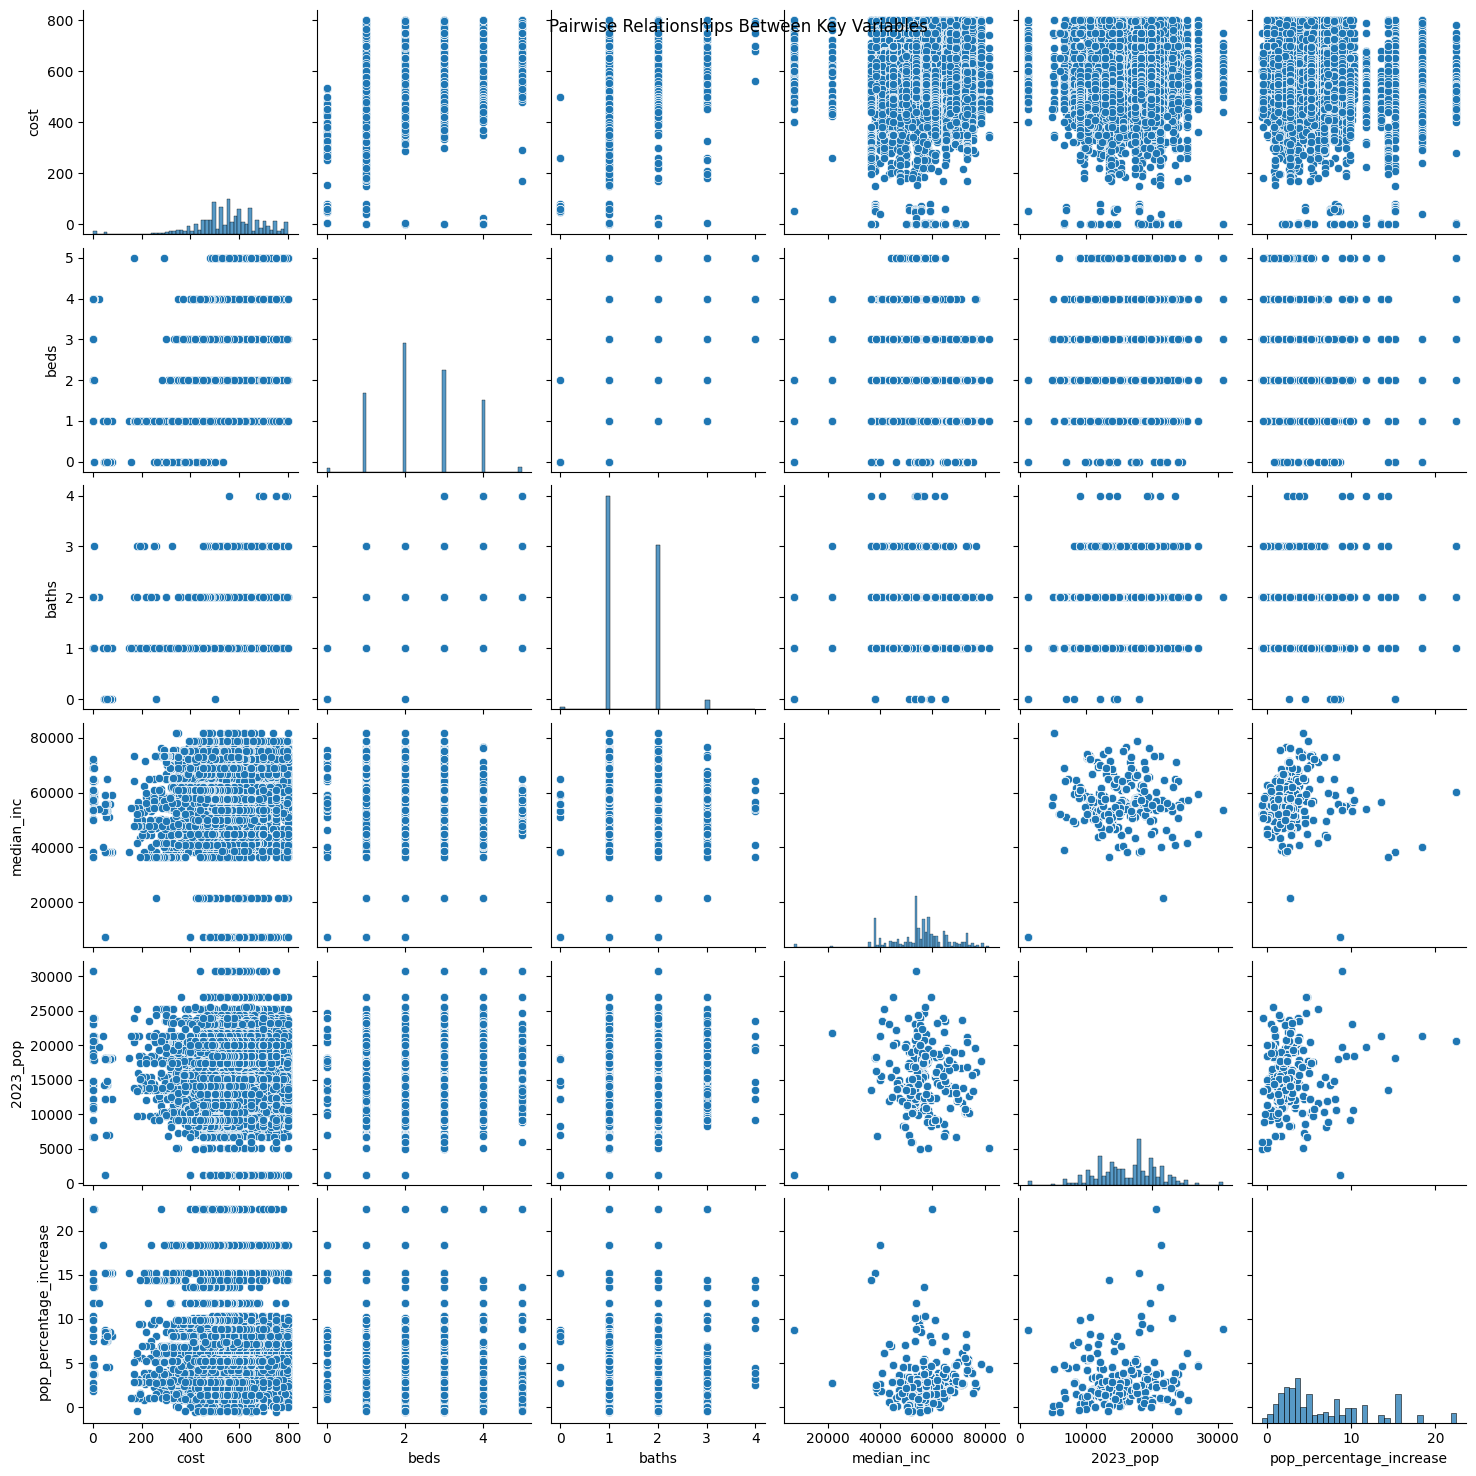

In [32]:
# Selecting a subset of relevant variables
selected_columns = df_prop[['cost', 'beds', 'baths', 'median_inc', '2023_pop', 'pop_percentage_increase']]
                            #  'parkings', 'schools', 'supermarkets', 'CBD']]
sns.pairplot(selected_columns)
plt.suptitle('Pairwise Relationships Between Key Variables')
plt.show()